# Encoding Time Series Data as Image Fields #

For this experiment, we are encoding the ECG200 dataset as gramian image fields and training a cnn (untrained resnet model). With very little optimization, we're able to acheive a 90% accuracy on the test/training split and 83% accuracy on previously unseen images (with the best performing hyperparameters).

The train and test sets both contain 100 items each with ~64% normal ECGs (indicating normal heartbeat) and ~35% ECGs indicating myocardial infarction. 

<img src="ECG.png" width="300px">

We are exporting the data from the Aretas platform using the GADF, batch normalization, 2.5x interpolation and vision color palette.

We no longer include the best perfroming models, so YMMV with whatever parameters happen to be set in the notebook. But feel free to download, adjust, and experiment!

In [7]:
from fastai.vision.all import *

In [8]:
image_data_path = Path("ECG200/train")

In [9]:
image_data_path.ls()

(#3) [Path('ECG200/train/-1'),Path('ECG200/train/1'),Path('ECG200/train/models')]

In [10]:
files = get_image_files(image_data_path)

In [11]:
len(files)

100

In [12]:
files[0]

Path('ECG200/train/-1/0.png')

In [13]:
files[0].parts[-2]

'-1'

In [14]:
def label_func(f):
    label = f.parts[-2]
    return label


In [15]:
set_seed(8888, True)
dls = ImageDataLoaders.from_path_func(
    image_data_path, 
    files, 
    label_func,
    valid_pct=0.2, 
    bs=8, 
    item_tfms=Resize((240,240), ResizeMethod.Squish)
)

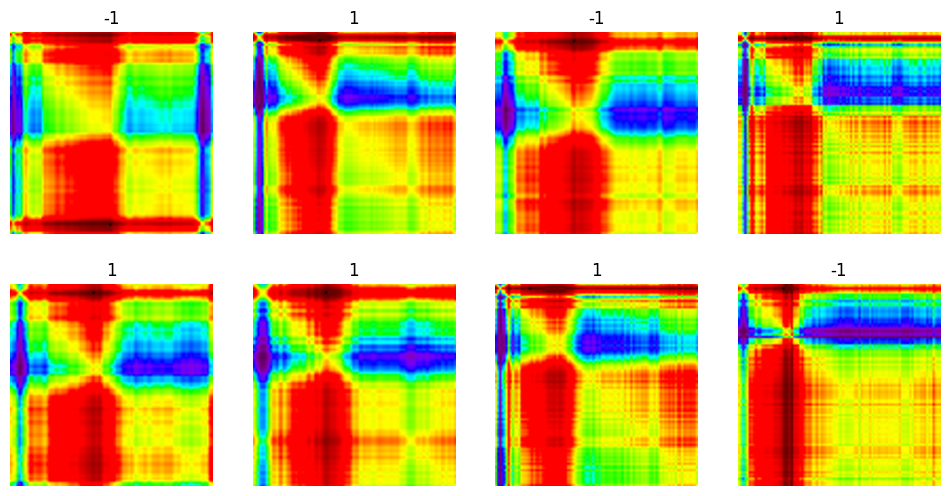

In [16]:
dls.show_batch()

SuggestedLRs(valley=0.0006918309954926372)

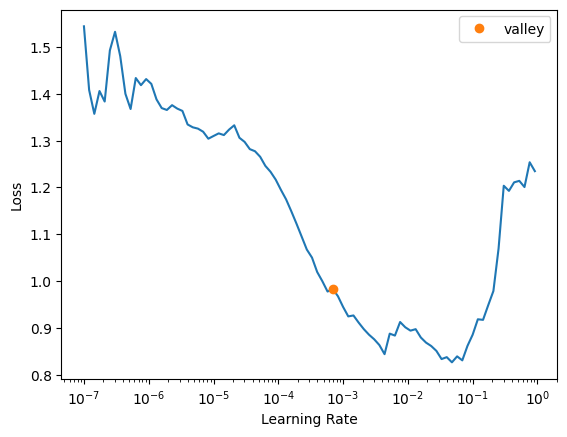

In [17]:
set_seed(8888, True)
learn = learn = Learner(dls, xresnet50(n_out=2), metrics=accuracy)
learn.lr_find(num_it=100)

In [18]:
lr =0.00019054606673307717
learn.fit_one_cycle(12, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.276461,0.978574,0.200000,00:00
1,0.955986,0.745640,0.450000,00:00
2,0.727398,0.307677,0.850000,00:00
3,0.593647,0.215090,0.850000,00:00
4,0.503701,0.242458,0.850000,00:00
5,0.429862,0.211042,0.850000,00:00
6,0.368889,0.220588,0.850000,00:00
7,0.322191,0.191572,0.850000,00:00
8,0.277893,0.204907,0.900000,00:00
9,0.259424,0.195081,0.900000,00:00


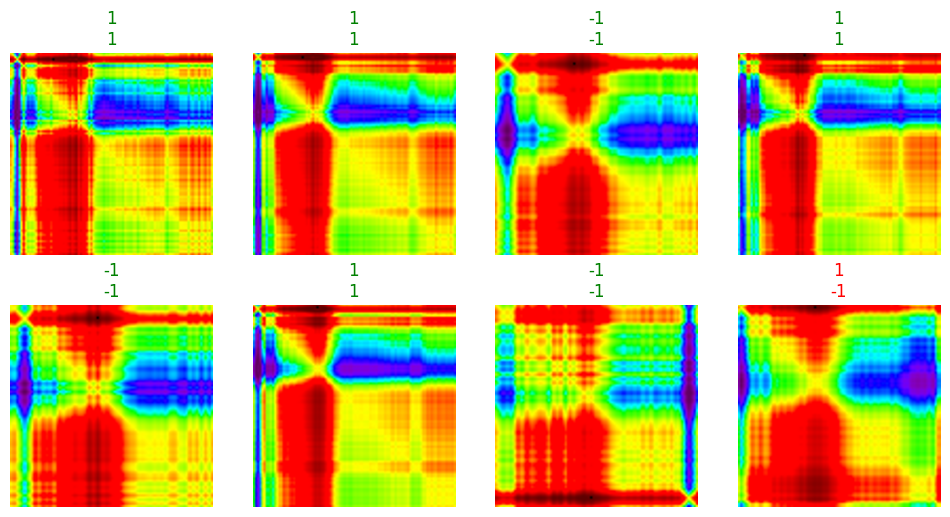

In [19]:
learn.show_results()

In [20]:
interp = Interpretation.from_learner(learn)

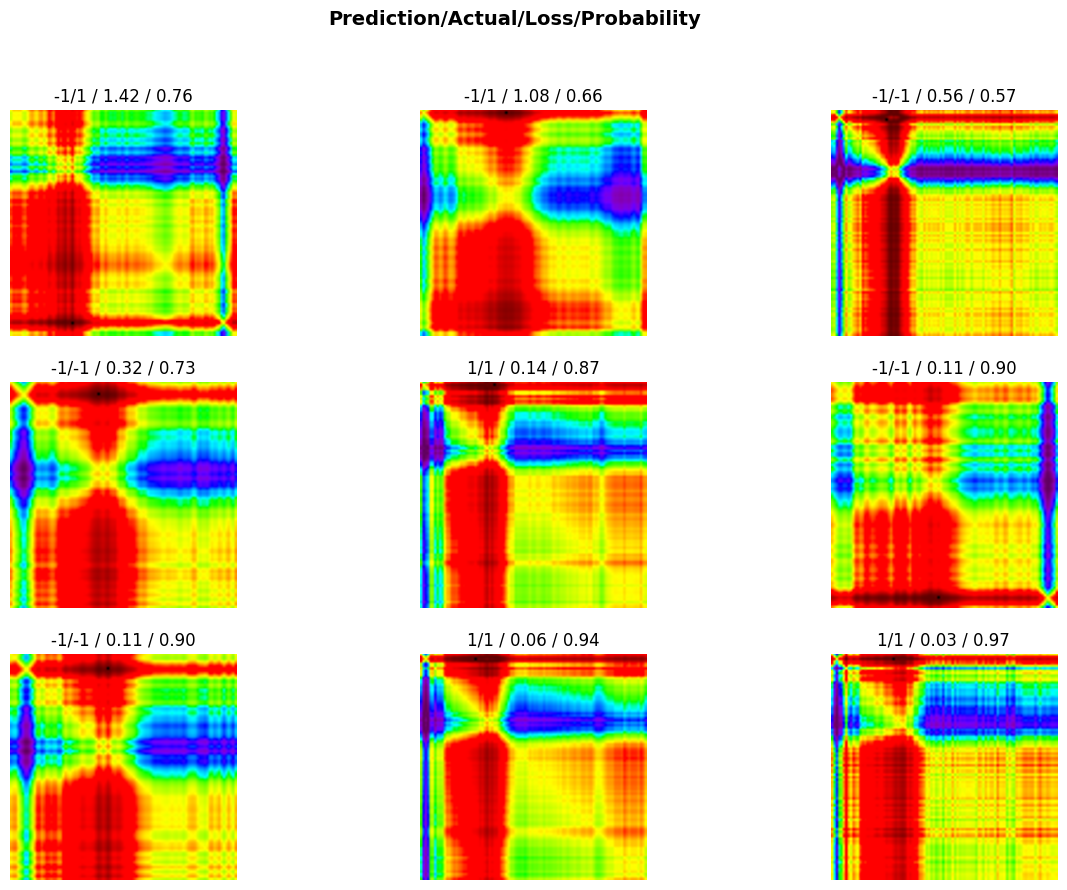

In [21]:
interp.plot_top_losses(9, figsize=(15,10))

### Testing ###

We test on previously unseed images and do not process at all in a dataloader block. We'll roll our own accuracy and confusion matrix. 

In [22]:
test_set_path = Path("Y:/ai-time-series-classification-export-gaf/ECG200/test/")
test_set_images = get_image_files(test_set_path)
test_set_images

(#100) [Path('Y:/ai-time-series-classification-export-gaf/ECG200/test/-1/104.png'),Path('Y:/ai-time-series-classification-export-gaf/ECG200/test/-1/109.png'),Path('Y:/ai-time-series-classification-export-gaf/ECG200/test/-1/110.png'),Path('Y:/ai-time-series-classification-export-gaf/ECG200/test/-1/112.png'),Path('Y:/ai-time-series-classification-export-gaf/ECG200/test/-1/113.png'),Path('Y:/ai-time-series-classification-export-gaf/ECG200/test/-1/114.png'),Path('Y:/ai-time-series-classification-export-gaf/ECG200/test/-1/118.png'),Path('Y:/ai-time-series-classification-export-gaf/ECG200/test/-1/120.png'),Path('Y:/ai-time-series-classification-export-gaf/ECG200/test/-1/126.png'),Path('Y:/ai-time-series-classification-export-gaf/ECG200/test/-1/128.png')...]

In [23]:
%%capture
def get_conf_matrix(debug=False):
    
    accuracy = [[0.0,0.0],[0.0,0.0]]
    
    for i in test_set_images:
        
        result = learn.predict(i);
        actual = label_func(i)
        prediction = result[0]
        
        print(prediction, actual)
        
        if debug:
            
            print("---------------------------------")
            print("Actual:" + actual)
            print("Prediction:" + result[0])
            target_prob = result[2][0]
            print(float(target_prob))
            print(result)
            print("---------------------------------")
            print('\n')

        # true positive
        if(actual == '-1' and result[0] == '-1'):
            accuracy[0][0] = accuracy[0][0] + 1.0

        # false negative
        if(actual == '-1' and result[0] == '1'):
            accuracy[1][0] = accuracy[1][0] + 1.0

        #false positive
        if(actual != '-1' and result[0] == '-1'):
            accuracy[0][1] = accuracy[0][1] + 1.0

        #true negative
        if(actual != '-1' and result[0] != '-1'):
            accuracy[1][1] = accuracy[1][1] + 1.0

    return accuracy

conf_matrix = get_conf_matrix()

Confustion matrix:

In [24]:
from IPython.display import display, HTML
display(HTML(pd.DataFrame(conf_matrix).to_html()))

,0,1
0,27.0,10.0
1,9.0,54.0


In [25]:
# accuracy
accuracy_t = Tensor(conf_matrix)
accuracy_val = accuracy_t.trace() / accuracy_t.sum()
print(accuracy_val)

tensor(0.8100)
